In [ ]:
# Load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm
tqdm.pandas()  # Enables progress_apply for pandas

import warnings
warnings.filterwarnings('ignore')


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Data Acquisition and Loading

- Link : https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/data

In [ ]:
# read a csv file and create a dataframe

fake = pd.read_csv('Fake.csv')
true = pd.read_csv('True.csv')

# Add label columns
fake['label'] = 1  # 1 for fake
true['label'] = 0  # 0 for real (true)

# Concatenate the two datasets
df = pd.concat([fake, true], ignore_index=True)

# Shuffle the dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df['label'].value_counts()

,count
label,
1,23481
0,21417


In [ ]:
# Display the top 10 rows of a dataframe
print("First ten rows of the dataset:")
df.head(10)

First ten rows of the dataset:


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0
5,Paul Ryan Responds To Dem’s Sit-In On Gun Con...,"On Wednesday, Democrats took a powerful stance...",News,"June 22, 2016",1
6,AWESOME! DIAMOND AND SILK Rip Into The Press: ...,President Trump s rally in FL on Saturday was ...,Government News,"Feb 19, 2017",1
7,STAND UP AND CHEER! UKIP Party Leader SLAMS Ge...,He s been Europe s version of the outspoken Te...,left-news,"Mar 8, 2016",1
8,North Korea shows no sign it is serious about ...,WASHINGTON (Reuters) - The State Department sa...,worldnews,"December 13, 2017",0
9,Trump signals willingness to raise U.S. minimu...,(This version of the story corrects the figur...,politicsNews,"May 4, 2016",0


In [ ]:
print("Dimensions of the data frame:", df.shape)

Dimensions of the data frame: (44898, 5)


In [ ]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None


In [ ]:
# Check for missing values
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [ ]:
# Descriptive Analytics
print("\nSummary Statistics:")
df.select_dtypes(["int", "float"]).describe().T


Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
label,44898.0,0.522985,0.499477,0.0,0.0,1.0,1.0,1.0


# 2. Visualizations


In [ ]:
label_colors = {0: 'steelblue', 1: 'crimson'}
label_names = {0: 'Real', 1: 'Fake'}

### 1. Word Count Distribution

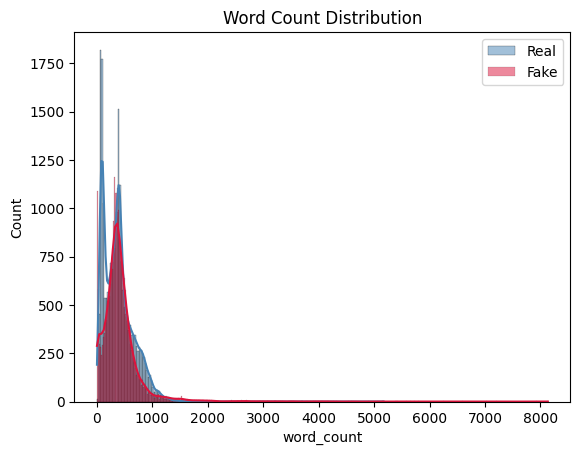

In [ ]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

sns.histplot(df[df['label'] == 0]['word_count'], color=label_colors[0], label=label_names[0], kde=True)
sns.histplot(df[df['label'] == 1]['word_count'], color=label_colors[1], label=label_names[1], kde=True)
plt.legend()
plt.title('Word Count Distribution')
plt.show()

### 2. News title length distribution

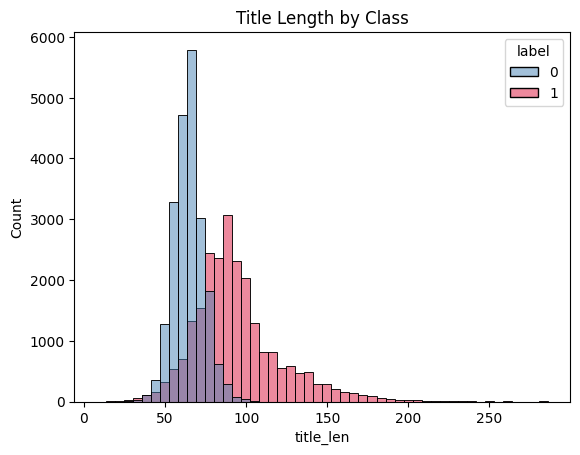

In [ ]:
df['title_len'] = df['title'].apply(lambda x: len(str(x)))

sns.histplot(data=df, x='title_len', hue='label', bins=50,
             palette=label_colors)
plt.xticks()
plt.title("Title Length by Class")
plt.show()

### 3. Word Cloud for Fake News

In [ ]:
fake_words = ' '.join(df[df['label']==1]['text'].dropna().astype(str).tolist())
wordcloud_fake = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(fake_words)

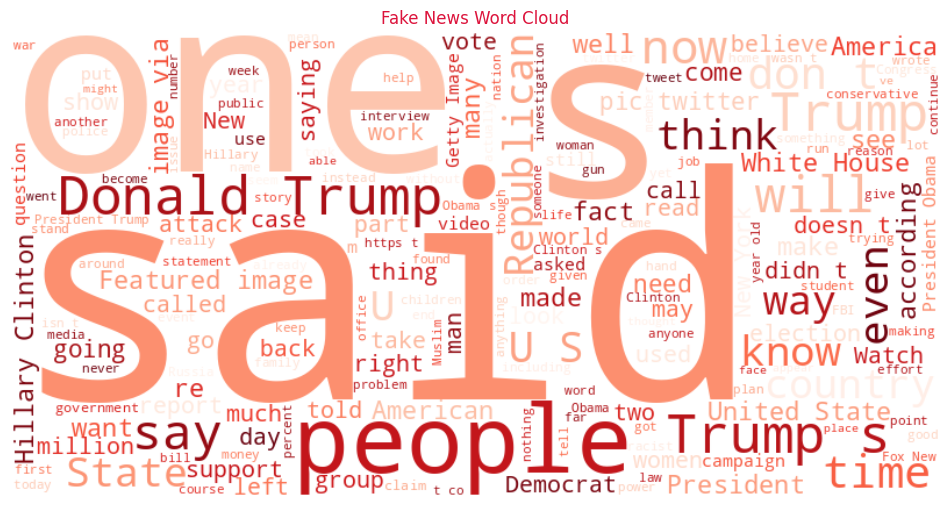

In [ ]:
# plot
plt.figure(figsize=(12,8))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud', color=label_colors[1])
plt.show()

### 4. Word Cloud for Real News

In [ ]:
real_words = ' '.join(df[df['label']==0]['text'].dropna().astype(str).tolist())
wordcloud_real = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(real_words)

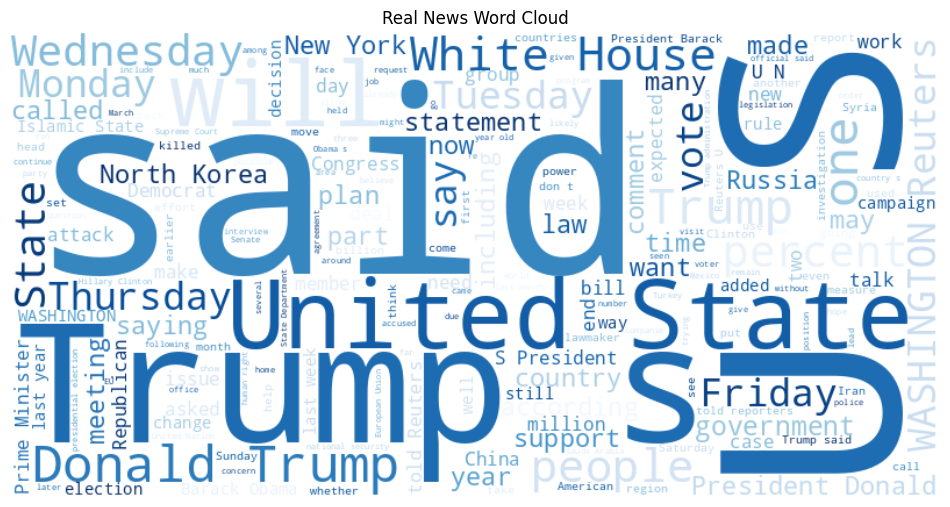

In [ ]:
# plot
plt.figure(figsize=(12,8))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('Real News Word Cloud')
plt.show()

### 5. Class Distribution

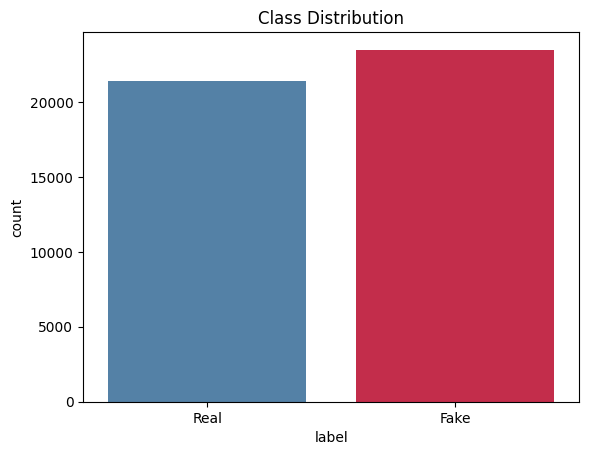

In [ ]:
sns.countplot(x='label', data=df, palette={ '0': 'steelblue', '1': 'crimson' })
plt.xticks([0,1], ['Real', 'Fake'])
plt.title("Class Distribution")
plt.show()

### 6. Top publishers

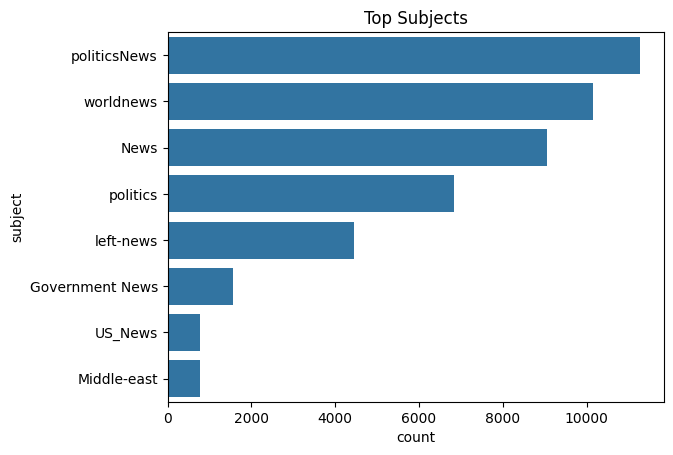

In [ ]:
if 'subject' in df.columns:
    sns.countplot(y='subject', data=df, order=df['subject'].value_counts().index)
    plt.title("Top Subjects")
    plt.show()

### 7. Time-based publishing trend


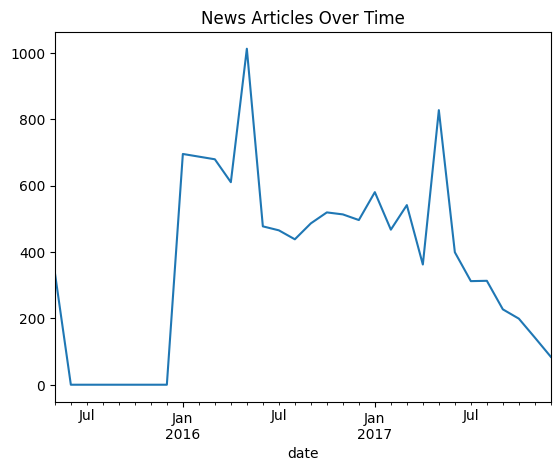

In [ ]:
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.set_index('date').resample('M').size().plot()
    plt.title("News Articles Over Time")
    plt.show()

# 3. Data Preparation

**Text preprocessing** :
- cleaning
- stopwords removal
- tokenization
- lemmatization

In [ ]:
def preprocess(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'\W', ' ', text)  # remove non-word characters
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    text = text.lower()

    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return ' '.join(tokens)

In [ ]:
df['text'] = df['text'].fillna('')

In [ ]:
#df['clean_text'] = df['text'].apply(preprocess)
df['clean_text'] = df['text'].progress_apply(preprocess)

100%|██████████| 44898/44898 [31:46<00:00, 23.56it/s]


In [ ]:
df.head()

,title,text,subject,date,label,word_count,title_len,clean_text
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,2017-02-13,1,171,89,21st century wire say ben stein reputable prof...
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,NaT,0,771,55,washington reuters u president donald trump re...
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,NaT,0,304,64,reuters puerto rico governor ricardo rossello ...
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,2017-05-22,1,183,89,monday donald trump embarrassed country accide...
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,NaT,0,529,55,glasgow scotland reuters u presidential candid...


In [ ]:
df.shape

(44898, 8)

In [ ]:
fake_words_clean_text = ' '.join(df[df['label']==1]['clean_text'].dropna().astype(str).tolist())
wordcloud_fake_clean_text = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(fake_words_clean_text)

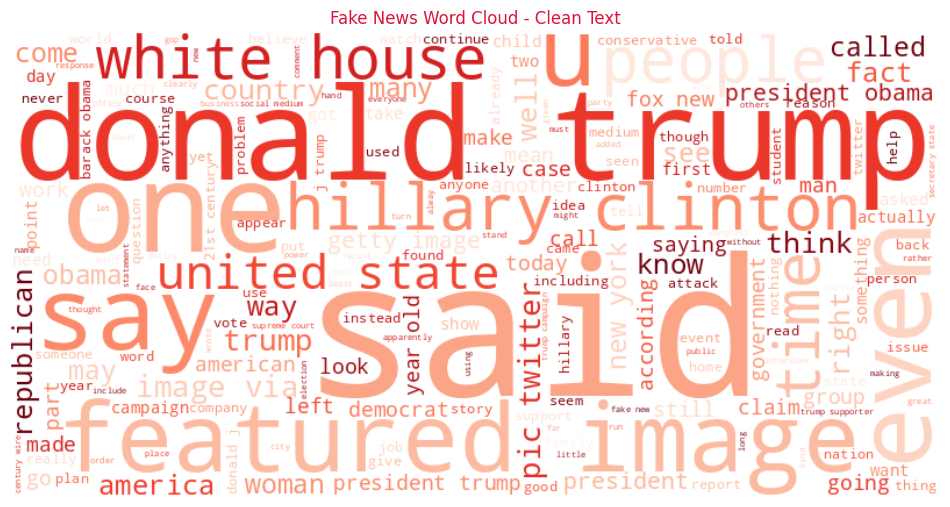

In [ ]:
# plot
plt.figure(figsize=(12,8))
plt.imshow(wordcloud_fake_clean_text, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud - Clean Text', color=label_colors[1])
plt.show()

In [ ]:
real_words_clean_text = ' '.join(df[df['label']==0]['clean_text'].dropna().astype(str).tolist())
wordcloud_real_clean_text = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(real_words_clean_text)

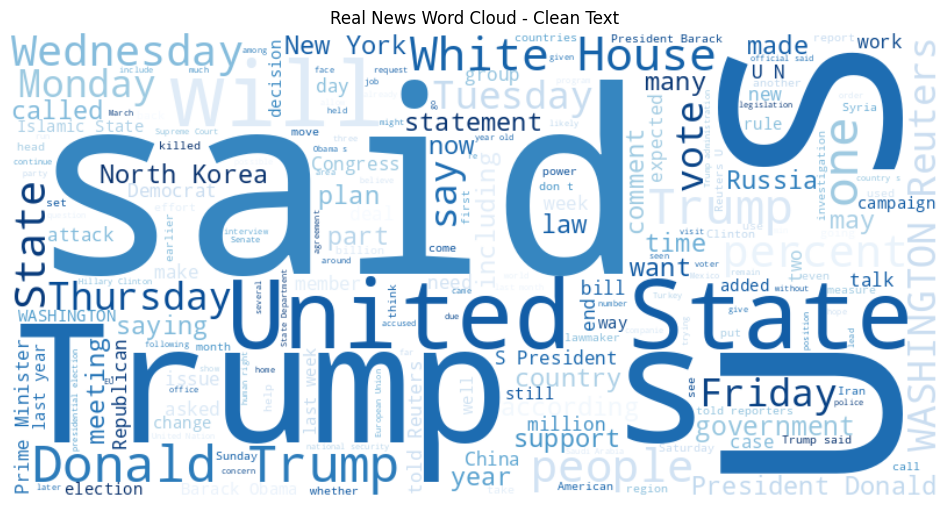

In [ ]:
# plot
plt.figure(figsize=(12,8))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('Real News Word Cloud - Clean Text')
plt.show()

**Train-Test Split**: Divided the dataset into training (80%) and testing (20%) sets.

In [ ]:
# Prepare train-test split
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)

**Feature engineering** using TF-IDF and word embeddings like GloVe or Word2Vec

## Feature Engineering with TF-IDF for Machine Learning Models

In [ ]:
tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Word Embeddings (GloVe) for Deep Learning Models

In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=300)
X_test_pad = pad_sequences(X_test_seq, maxlen=300)

# Load GloVe embeddings
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeff = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeff

# Create embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((20000, embedding_dim))

for word, i in word_index.items():
    if i < 20000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# 4. Model Development and Evaluation

**Model Training & Evaluation** : Designed and developed ML models. A mix of machine learning and deep learning models

In [ ]:
# Dictionary to hold machine learning models

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train))
}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    y_proba = model.predict_proba(X_test_tfidf)[:, 1]

    print(f"------ {name} ------")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    #print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test_tfidf)[:, 1]))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
    print()

------ Logistic Regression ------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4284
           1       0.99      0.98      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.98      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion Matrix:
[[4243   41]
 [  92 4604]]
ROC AUC Score: 0.998971550573665

------ Random Forest ------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4284
           1       1.00      1.00      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Confusion Matrix:
[[4272   12]
 [  13 4683]]
ROC AUC Score: 0.9999567544223822

------ XGBoost ------
Classification Report:
              precision    recall 

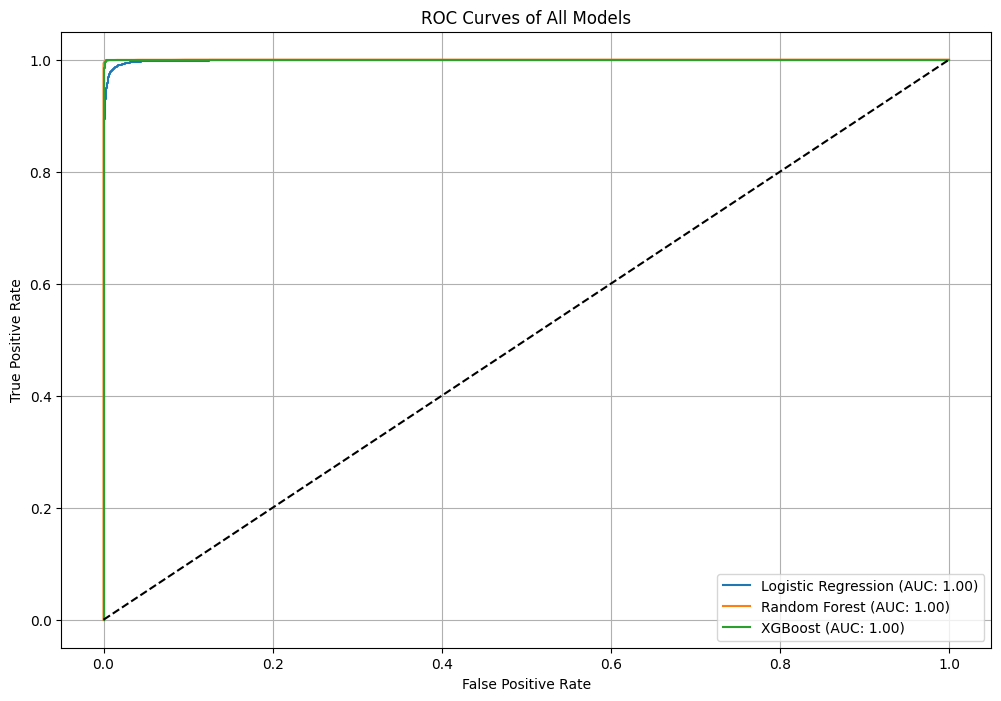

In [ ]:
# Plot ROC Curves
plt.figure(figsize=(12,8))

for name, model in models.items():
    y_proba = model.predict_proba(X_test_tfidf)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC: {roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of All Models')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# LSTM Model
model_lstm = Sequential([
    Embedding(input_dim=20000, output_dim=100, weights=[embedding_matrix], input_length=300, trainable=False),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train_pad, y_train, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.8748 - loss: 0.2940 - val_accuracy: 0.9325 - val_loss: 0.1702
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.9372 - loss: 0.1706 - val_accuracy: 0.9621 - val_loss: 0.1088
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.9669 - loss: 0.0999 - val_accuracy: 0.9699 - val_loss: 0.0840
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.9760 - loss: 0.0750 - val_accuracy: 0.9790 - val_loss: 0.0621
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 243s 997ms/step - accuracy: 0.9700 - loss: 0.0798 - val_accuracy: 0.9781 - val_loss: 0.0728


In [ ]:
# CNN Model
model_cnn = Sequential([
    Embedding(input_dim=20000, output_dim=100, weights=[embedding_matrix], input_length=300, trainable=False),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=5),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train_pad, y_train, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 75s 327ms/step - accuracy: 0.8225 - loss: 0.3833 - val_accuracy: 0.9713 - val_loss: 0.0928
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 74s 292ms/step - accuracy: 0.9711 - loss: 0.0894 - val_accuracy: 0.9816 - val_loss: 0.0605
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 84s 302ms/step - accuracy: 0.9827 - loss: 0.0591 - val_accuracy: 0.9847 - val_loss: 0.0454
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 84s 311ms/step - accuracy: 0.9903 - loss: 0.0375 - val_accuracy: 0.9886 - val_loss: 0.0366
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 65s 289ms/step - accuracy: 0.9921 - loss: 0.0295 - val_accuracy: 0.9886 - val_loss: 0.0323


In [46]:
# Predict probabilities and classes for LSTM
y_pred_prob_lstm = model_lstm.predict(X_test_pad)
y_pred_class_lstm = (y_pred_prob_lstm > 0.5).astype("int32")

# Predict probabilities and classes for CNN
y_pred_prob_cnn = model_cnn.predict(X_test_pad)
y_pred_class_cnn = (y_pred_prob_cnn > 0.5).astype("int32")

281/281 ━━━━━━━━━━━━━━━━━━━━ 44s 155ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step


In [47]:
print(f"------ LSTM ------")
print("Classification Report:")
print(classification_report(y_test, y_pred_class_lstm))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class_lstm))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_lstm))
print()

print(f"------ 1D CNN ------")
print("Classification Report:")
print(classification_report(y_test, y_pred_class_cnn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class_cnn))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_class_cnn))
print()

------ LSTM ------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4284
           1       0.98      0.98      0.98      4696

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980

Confusion Matrix:
[[4171  113]
 [  72 4624]]
ROC AUC Score: 0.9966156110371462

------ 1D CNN ------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4284
           1       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion Matrix:
[[4232   52]
 [  26 4670]]
ROC AUC Score: 0.9911625922373493

